In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.display import display

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
data = pd.read_csv('masterlist_1719.csv')

display(data.head())

,Unnamed: 0,Rk,Gcar,Gtm,Date,Tm,HORA,Opp,Rslt,Inngs,Dec,DR,IP,H,ER,BB,SO,Pit
0,0,1,34,5,Apr 8,PHI,NaN,WSN,"W,17-3",GS-6,W(1-0),99,6.0,7,3,2,7,89
1,1,2,35,10,Apr 14,PHI,@,WSN,"L,2-3",GS-5,NaN,5,5.0,6,1,0,6,90
2,2,3,36,15,Apr 20,PHI,@,NYM,"W,6-4",GS-5,W(2-0),5,5.0,7,4,4,2,96
3,4,4,37,41,May 21,PHI,@,PIT,"L,0-1",GS-7,L(2-1),30,7.0,4,1,2,5,89
4,5,5,38,46,May 26,PHI,NaN,CIN,"L,2-5",GS-6,L(2-2),4,6.0,6,5,2,5,97


In [12]:
#average strikeouts per game

n_games = data.shape[0]

n_features = data.shape[1] - 1

n_away = len(data[data.HORA == '@'])

away_rate = (float(n_away) / (n_games)) * 100

print("Total number of matches: {}".format(n_games))
print("Total number of features: {}".format(n_features))
print("Total number of away teams: {}".format(n_away))
print("Rate of away teams: {:.2f}%".format(away_rate))



Total number of matches: 12651
Total number of features: 17
Total number of away teams: 6297
Rate of away teams: 49.77%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA77802E08>,
      dtype=object)

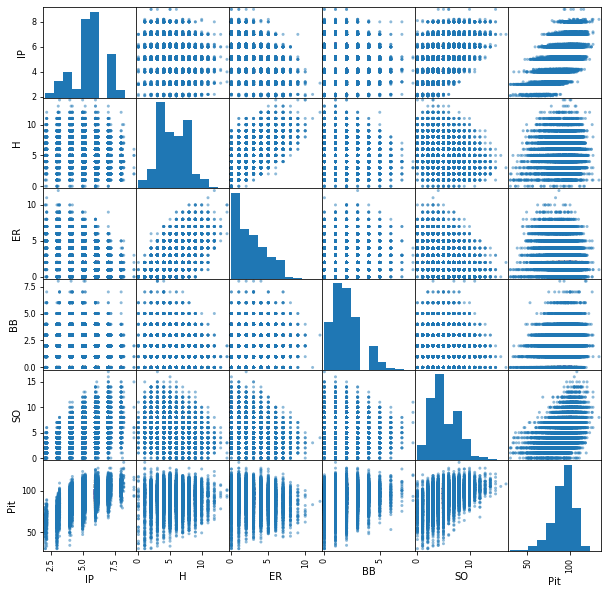

In [22]:
#build a scatter matrix 
#from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix
scatter_matrix(data[['IP', 'H', 'ER', 'BB', 'SO', 'Pit']], figsize=(10,10))


In [23]:
#preparing the data 

x_all = data.drop(['SO'],1)
y_all = data['SO']

from sklearn.preprocessing import scale

cols = [['IP', 'H', 'ER', 'BB', 'Pit']]
for col in cols:
    x_all[col] = scale(x_all[col])


In [26]:
#last 3 games for both sides

def preprocess_features(X):
    output = pd.DataFrame(index = X.index)
    
    for col, col_data in X.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
            
        output = output.join(col_data)
    return output
x_all = preprocess_features(x_all)
print("Processed feature columns ({} total features):\n{}".format(len(x_all.columns), list(x_all.columns)))

Processed feature columns (1181 total features):
['Unnamed: 0', 'Rk', 'Gcar', 'Gtm', 'Date_Apr\xa01', 'Date_Apr\xa01(1)', 'Date_Apr\xa01(2)', 'Date_Apr\xa010', 'Date_Apr\xa011', 'Date_Apr\xa012', 'Date_Apr\xa013', 'Date_Apr\xa014', 'Date_Apr\xa015', 'Date_Apr\xa016', 'Date_Apr\xa017', 'Date_Apr\xa017(1)', 'Date_Apr\xa017(2)', 'Date_Apr\xa018', 'Date_Apr\xa019', 'Date_Apr\xa02', 'Date_Apr\xa020', 'Date_Apr\xa020(1)', 'Date_Apr\xa020(2)', 'Date_Apr\xa021', 'Date_Apr\xa022', 'Date_Apr\xa023', 'Date_Apr\xa023(1)', 'Date_Apr\xa023(2)', 'Date_Apr\xa024', 'Date_Apr\xa025', 'Date_Apr\xa025(1)', 'Date_Apr\xa025(2)', 'Date_Apr\xa026', 'Date_Apr\xa027', 'Date_Apr\xa027(1)', 'Date_Apr\xa027(2)', 'Date_Apr\xa028', 'Date_Apr\xa028(1)', 'Date_Apr\xa028(2)', 'Date_Apr\xa029', 'Date_Apr\xa03', 'Date_Apr\xa030', 'Date_Apr\xa04', 'Date_Apr\xa05', 'Date_Apr\xa06', 'Date_Apr\xa07', 'Date_Apr\xa08', 'Date_Apr\xa09', 'Date_Aug\xa01', 'Date_Aug\xa010', 'Date_Aug\xa011', 'Date_Aug\xa011(1)', 'Date_Aug\xa011(2)

In [27]:
print("\nFeature values:")
display(x_all.head())


Feature values:


,Unnamed: 0,Rk,Gcar,Gtm,Date_Apr 1,Date_Apr 1(1),Date_Apr 1(2),Date_Apr 10,Date_Apr 11,Date_Apr 12,...,Dec_W(9-6),Dec_W(9-7),Dec_W(9-8),Dec_W(9-9),DR,IP,H,ER,BB,Pit
0,0,1,34,5,0,0,0,0,0,0,...,0,0,0,0,99,0.432497,0.743997,0.203235,0.115441,-0.230326
1,1,2,35,10,0,0,0,0,0,0,...,0,0,0,0,5,-0.378159,0.284097,-0.829140,-1.387079,-0.153458
2,2,3,36,15,0,0,0,0,0,0,...,0,0,0,0,5,-0.378159,0.743997,0.719423,1.617962,0.307754
3,4,4,37,41,0,0,0,0,0,0,...,0,0,0,0,30,1.243153,-0.635702,-0.829140,0.115441,-0.230326
4,5,5,38,46,0,0,0,0,0,0,...,0,0,0,0,4,0.432497,0.284097,1.235611,0.115441,0.384623


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size = 0.2,
                                                   random_state = 0)

In [45]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H', average = 'micro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


In [ ]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 10120. . .


C:\Users\linto\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linto\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\linto\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You 

Trained model in 3.4278 seconds
Made predictions in 0.0818 seconds.
0.18616600790513835 0.18616600790513835
F1 score and accuracy score for training set: 0.1862 , 0.1862.
Made predictions in 0.0229 seconds.
F1 score and accuracy score for test set: 0.1881 , 0.1881.

Training a SVC using a training set size of 10120. . .
